In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File Directory for both the train and test
train_path = "/content/drive/MyDrive/Data/train"
val_path = "/content/drive/MyDrive/Data/valid"
test_path = "/content/drive/MyDrive/Data/test"

In [ ]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenoCarcinoma': 195, 'squamousCellCarcinoma': 155, 'normal': 148} 

 {'adenoCarcinoma': 23, 'squamousCellCarcinoma': 15, 'normal': 13} 

 {'squamousCellCarcinoma': 90, 'adenoCarcinoma': 120, 'normal': 54}


In [ ]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 498 images belonging to 3 classes.


In [ ]:
train_data.class_indices

{'adenoCarcinoma': 0, 'normal': 1, 'squamousCellCarcinoma': 2}

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 51 images belonging to 3 classes.


In [ ]:
val_data.class_indices

{'adenoCarcinoma': 0, 'normal': 1, 'squamousCellCarcinoma': 2}

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 264 images belonging to 3 classes.


In [ ]:
test_data.class_indices

{'adenoCarcinoma': 0, 'normal': 1, 'squamousCellCarcinoma': 2}

VGG16 Implementation

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(350,350,3)
)

In [ ]:
NUM_CLASSES = 3

vgg_model = Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg_model.layers[0].trainable = False

vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 10, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_1 (Dropout)         (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 153603    
                                                                 
Total params: 14,868,291
Trainable params: 153,603
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_vgg_best_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );
call_back = [mc];

In [ ]:
# Fitting the Model
vgg = vgg_model.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back
    )

Epoch 1/10
99/99 [==============================] - ETA: 0s - loss: 1.5751 - accuracy: 0.6471
Epoch 1: val_accuracy improved from -inf to 0.68000, saving model to ./ct_vgg_best_model.hdf5
99/99 [==============================] - 85s 855ms/step - loss: 1.5751 - accuracy: 0.6471 - val_loss: 1.6024 - val_accuracy: 0.6800
Epoch 2/10
99/99 [==============================] - ETA: 0s - loss: 1.2357 - accuracy: 0.7099
Epoch 2: val_accuracy did not improve from 0.68000
99/99 [==============================] - 19s 186ms/step - loss: 1.2357 - accuracy: 0.7099 - val_loss: 2.7851 - val_accuracy: 0.5600
Epoch 3/10
99/99 [==============================] - ETA: 0s - loss: 1.1409 - accuracy: 0.7221
Epoch 3: val_accuracy improved from 0.68000 to 0.72000, saving model to ./ct_vgg_best_model.hdf5
99/99 [==============================] - 19s 189ms/step - loss: 1.1409 - accuracy: 0.7221 - val_loss: 0.5882 - val_accuracy: 0.7200
Epoch 4/10
99/99 [==============================] - ETA: 0s - loss: 1.1143 - acc

In [ ]:
# Loading the Best Fit Model 
model = load_model("/content/drive/MyDrive/Data/ct_vgg_best_model.hdf5")

In [ ]:
# Checking the Accuracy of the Model 
accuracy_vgg = model.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of the model is = {accuracy_vgg*100} %")

The accuracy of the model is = 92.42424368858337 %


In [ ]:
vgg.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

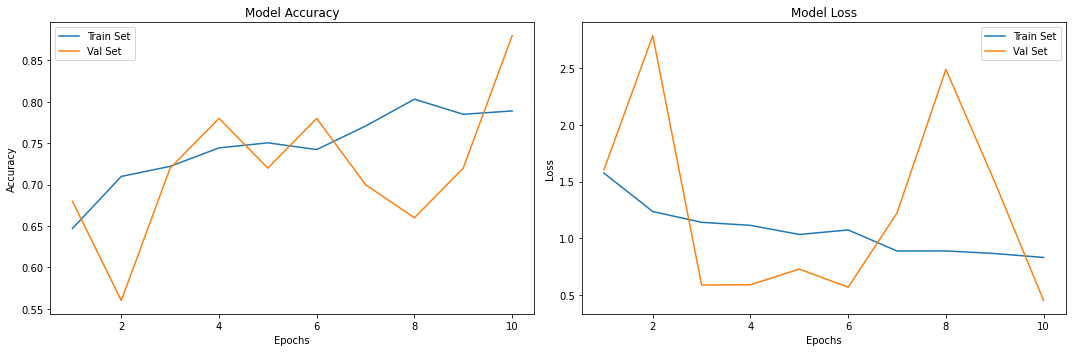

In [ ]:
# Plot model performance
acc = vgg.history['accuracy']
val_acc = vgg.history['val_accuracy']
loss = vgg.history['loss']
val_loss = vgg.history['val_loss']
epochs_range = range(1, len(vgg.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
classes_dir = ["Adenocarcinoma","Normal","Squamous cell carcinoma"]
# Loading Image
img = image.load_img("000114.png", target_size=(350,350))
# Normalizing Image
norm_img = image.img_to_array(img)/255
# Converting Image to Numpy Array
input_arr_img = np.array([norm_img])
# Getting Predictions
pred = np.argmax(model.predict(input_arr_img))
# Printing Model Prediction
print(model.predict(input_arr_img))
print(classes_dir[pred])

[[1.0000000e+00 1.2166725e-18 2.4327599e-02]]
Adenocarcinoma


In [ ]:
converter = tf.TFLiteConverter.from_keras_model(model)

In [ ]:
tfmodel = converter.convert()

In [ ]:
open('model.tflite','wb').write(tfmodel)